In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

data = pd.read_csv("microdata.csv")

data['c_birth_year']=pd.to_datetime(data['c_birth_date']).dt.year


data.drop(columns=['c_birth_date', 'marr_date', 'gr_m_community'], inplace=True)

In [2]:
data.describe()

,Unnamed: 0,m_age_at_birth,f_age_at_birth,m_annual_salary_tm2,f_annual_salary_tm2,gr_m_family_status,m_edu4,f_edu4,edu4_comp,c_birth_year
count,32234.000000,32234.000000,30048.000000,32230.000000,30043.000000,32234.000000,32047.000000,29648.000000,29482.000000,32234.000000
mean,16117.500000,26.066110,29.232994,13025.175232,15986.812664,1.618415,2.481418,2.479897,0.635472,1998.275579
std,9305.298625,5.077912,6.141691,10397.020006,12935.825221,0.607161,0.881139,0.829394,0.807965,5.205613
min,1.000000,14.000000,14.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1990.000000
25%,8059.250000,22.000000,25.000000,3929.285095,3766.359985,1.000000,2.000000,2.000000,0.000000,1994.000000
50%,16117.500000,26.000000,29.000000,12527.424805,15542.679688,2.000000,2.000000,2.000000,0.000000,1998.000000
75%,24175.750000,29.000000,33.000000,19739.487793,24615.714844,2.000000,3.000000,3.000000,1.000000,2003.000000
max,32234.000000,46.000000,69.000000,85272.406250,75627.320312,4.000000,4.000000,4.000000,2.000000,2007.000000


* 1 - Unmarried couple
* 2 - Married couple
* 3 - Single
* 4 - Divorced

In [3]:
data['gr_m_family_status'].value_counts()

gr_m_family_status
2    17776
1    13732
4      706
3       20
Name: count, dtype: int64

### Model A
Only variables of Salary and Family Status. Salary == 0 is removed for the distribution to look more 'Normal'

In [4]:
model_a_data = data[['m_annual_salary_tm2', 'gr_m_family_status']][data['m_annual_salary_tm2']>0]

In [5]:
model_a_data.head()

,m_annual_salary_tm2,gr_m_family_status
0,7862.390137,1
1,17438.910156,2
3,17938.720703,1
4,16819.619141,2
5,4532.509766,1


In [16]:
# Encode family status as integers for modeling
encoded_family_status = np.array([status - 1 for status in model_a_data['gr_m_family_status']],
                                dtype=np.uint32)
salary = model_a_data['m_annual_salary_tm2']

# Define the PyMC model with explicit initial values
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sigma=10, shape=4, testval=np.zeros(4))  # Set initial values to zeros
    beta = pm.Normal('beta', mu=0, sigma=10, testval=0)  # Set initial value to 0

    eta = alpha[encoded_family_status] + beta * np.array(salary)

    family_status_likelihood = pm.Categorical('family_status_likelihood', p=pm.math.softmax(eta), observed=encoded_family_status)

    trace = pm.sample(500, tune=500, init='adapt_diag', nuts={'max_treedepth': 15} )

/var/folders/7f/10kbdnbn4qd234t42l72cc9h0000gn/T/ipykernel_43981/4017092011.py:8: FutureWarning: The `testval` argument is deprecated; use `initval`.
  alpha = pm.Normal('alpha', mu=0, sigma=10, shape=4, testval=np.zeros(4))  # Set initial values to zeros
/var/folders/7f/10kbdnbn4qd234t42l72cc9h0000gn/T/ipykernel_43981/4017092011.py:9: FutureWarning: The `testval` argument is deprecated; use `initval`.
  beta = pm.Normal('beta', mu=0, sigma=10, testval=0)  # Set initial value to 0
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


ValueError: Not enough samples to build a trace.

array([[<Axes: ylabel='alpha\n1'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='alpha\n2'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='alpha\n3'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='alpha\n0', ylabel='beta'>,
        <Axes: xlabel='alpha\n1'>, <Axes: xlabel='alpha\n2'>,
        <Axes: xlabel='alpha\n3'>]], dtype=object)

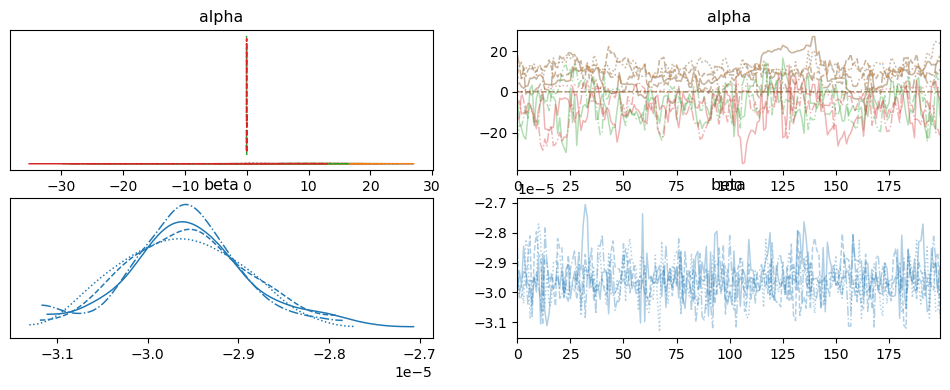

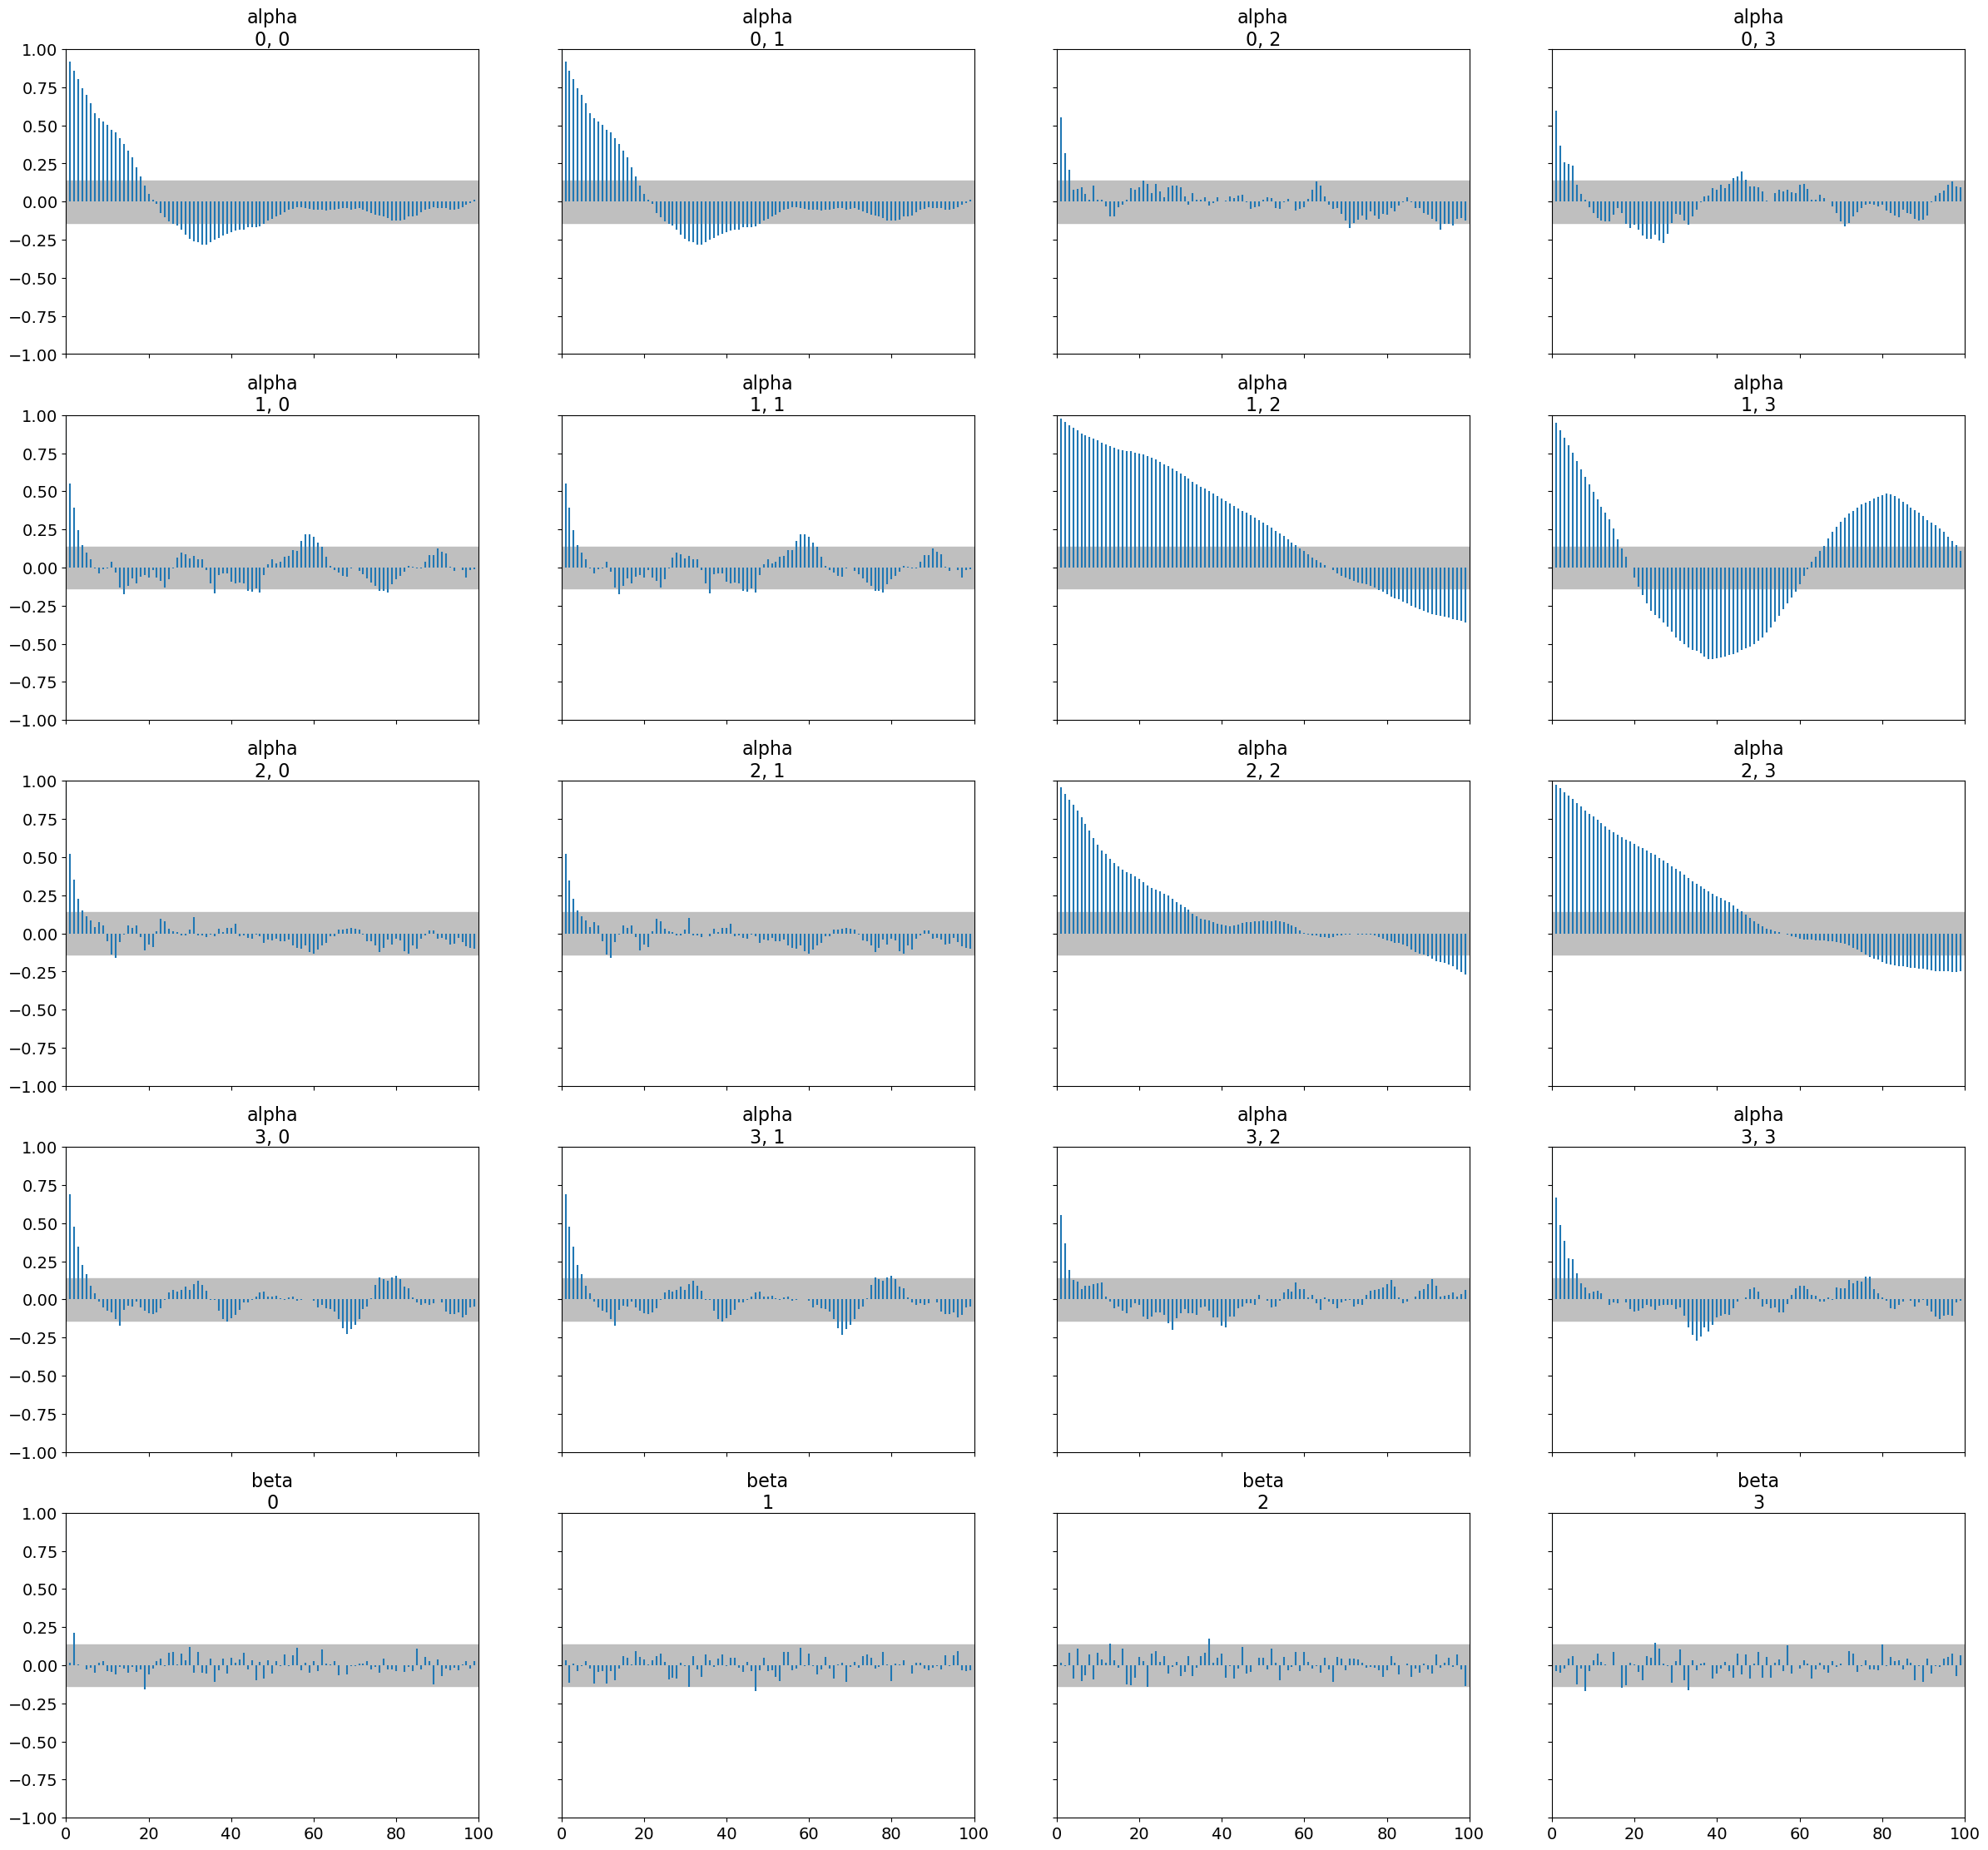

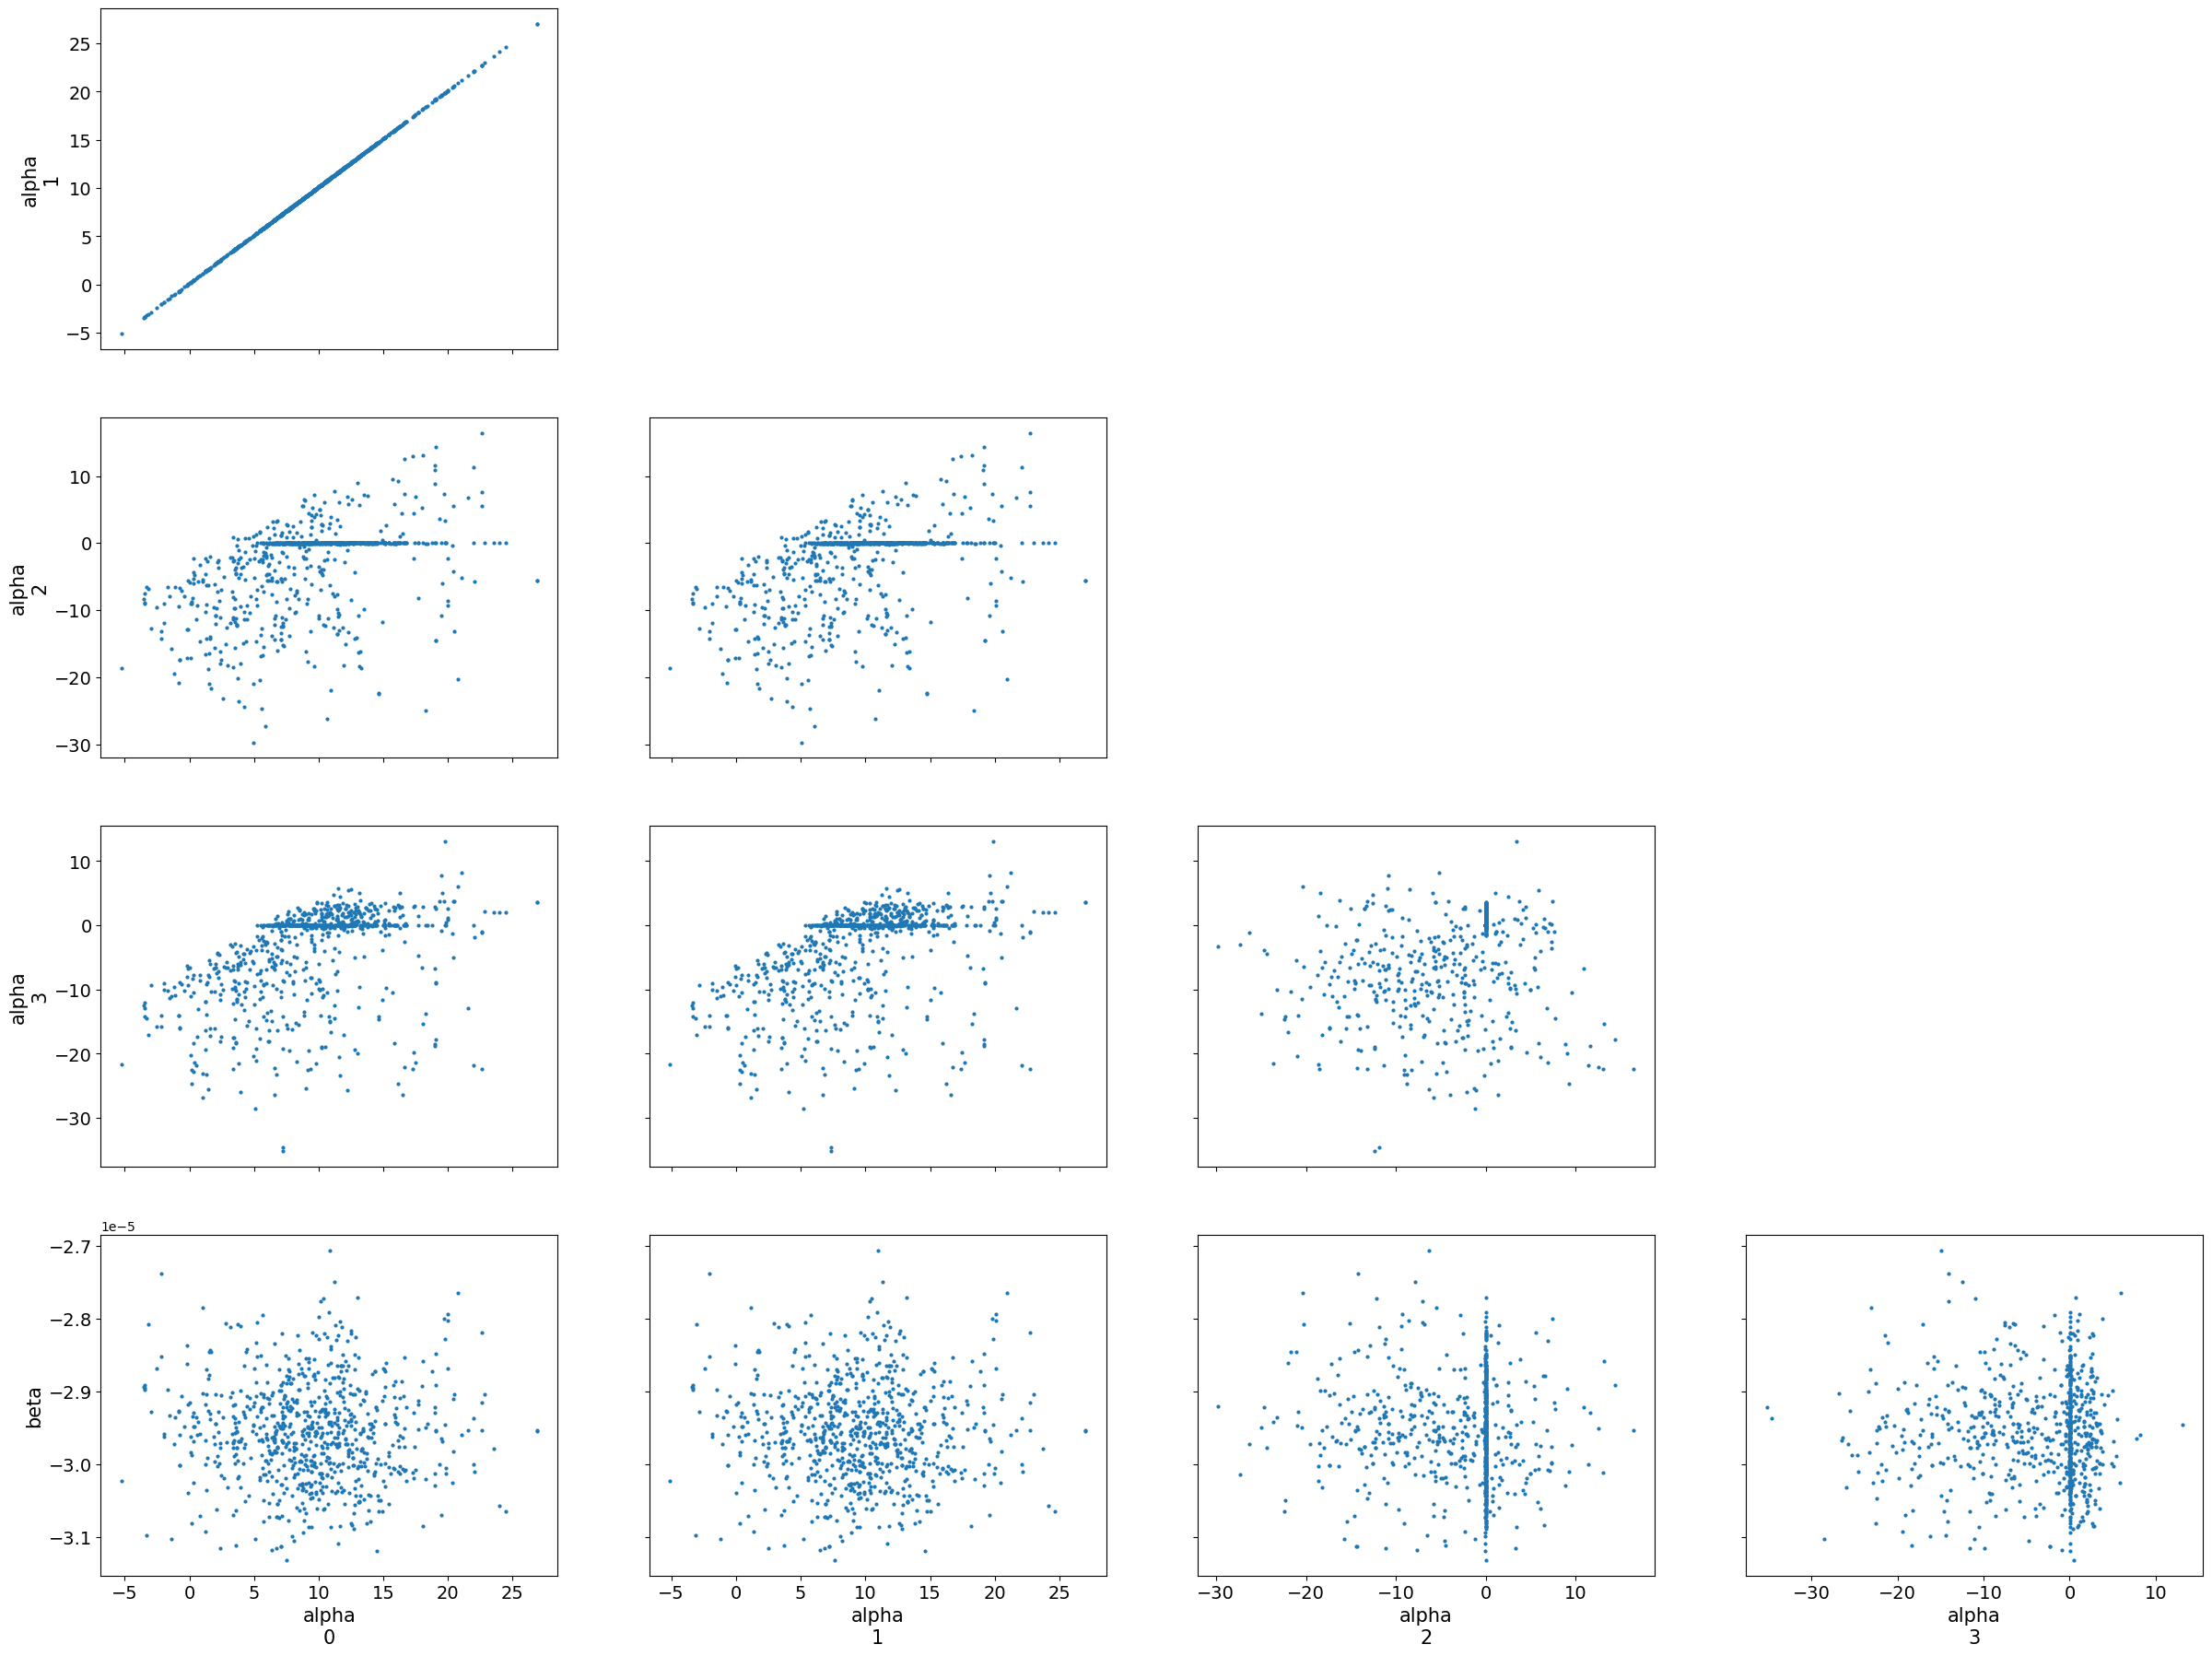

In [12]:
# Visualize trace plots
az.plot_trace(trace)

# Compute Gelman-Rubin statistic
pm.summary(trace, var_names=['alpha', 'beta'])

# Calculate effective sample size
pm.summary(trace, var_names=['alpha', 'beta'])

# Plot autocorrelation
az.plot_autocorr(trace, var_names=['alpha', 'beta'])

# Check for divergences
pm.summary(trace, var_names=['alpha', 'beta'])
az.plot_pair(trace, var_names=['alpha', 'beta'])
